In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import pickle as pkl

from ex_cosmology import p

# adaptive-wavelets modules
import awave
from awave.data.cosmology import get_dataloader, load_pretrained_model
from awave.data.cosmology import get_validation

# ICA/dictionarylearning
from sklearn.decomposition import FastICA
from sklearn.decomposition import DictionaryLearning, MiniBatchDictionaryLearning
from sklearn.feature_extraction import image
from skimage.transform import rescale

In [3]:
awave.data.cosmology

<module 'awave.data.cosmology' from '/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/awave/data/cosmology.py'>

In [2]:
# get dataloader and model
train_loader, val_loader = get_dataloader(p.data_path,
                                          img_size=p.img_size[2],
                                          split_train_test=True,
                                          batch_size=p.batch_size)

In [32]:
# data matrix
imgs = train_loader.dataset.dataset.imgs[:100,...]

patch_size = 12
X = []
for i in range(len(imgs)):
    patches = image.extract_patches_2d(imgs[i], (patch_size, patch_size), max_patches=50)
    X.append(patches)
X = np.stack(X, axis=0).reshape(-1,patch_size,patch_size)
print(X.shape)
X = X.reshape(-1, patch_size**2)

(5000, 12, 12)


In [42]:
transformer = MiniBatchDictionaryLearning(n_components=3000, alpha=1, batch_size=200, random_state=0, n_jobs=-1)
# transformer = DictionaryLearning(n_components=64, alpha=5, random_state=0)
S = transformer.fit_transform(X)
A = transformer.components_

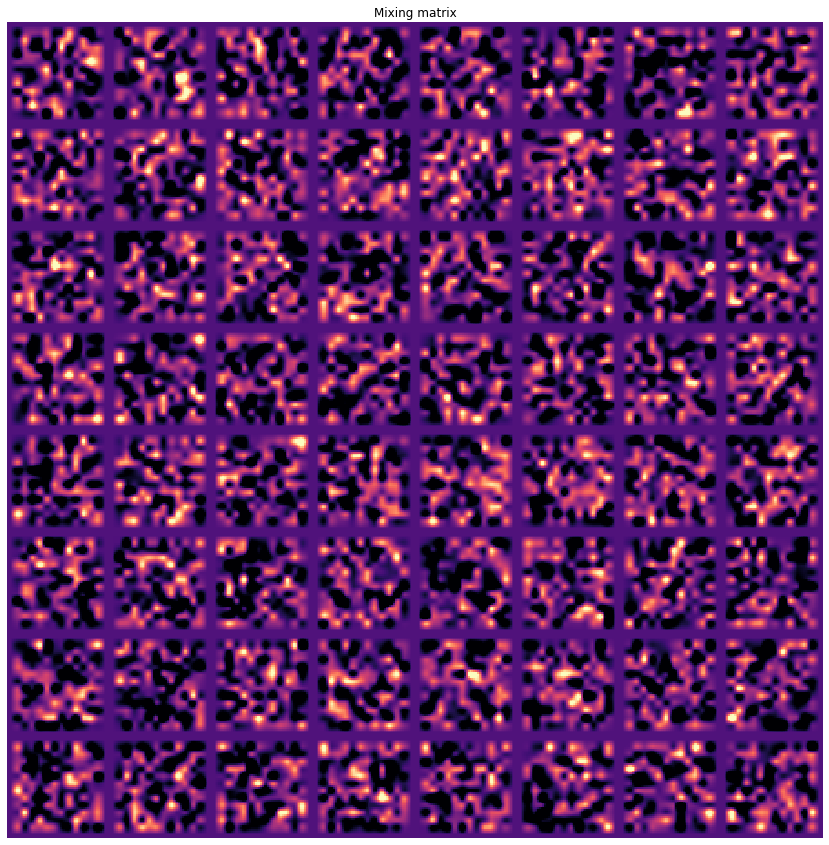

In [43]:
# dic = pkl.load(open('results/ICA_n_components={}.pkl'.format(500), 'rb'))
# S = dic['S']
# A = dic['A']

plt.figure(figsize=(15,15))
p = patch_size + 2
n_row = 8
n_col = 8
mosaic = np.zeros((p*n_row,p*n_col))
indx = 0
normalize = False
for i in range(n_row):
    for j in range(n_col):
        im = A[indx].reshape((patch_size,patch_size))
        if normalize:
            im = (im-np.min(im))
            im = im/np.max(im)
        mosaic[i*p:(i+1)*p,j*p:(j+1)*p] = np.pad(im,(1,1),mode='constant')
        indx += 1
plt.title("Mixing matrix")
plt.imshow(rescale(mosaic,4,mode='constant'), cmap='magma', vmax=0.15, vmin=-0.05)
plt.axis('off')    
plt.show() 

In [44]:
X_hat = S @ A
print(np.mean(np.sum((X_hat - X) ** 2, axis=1) / np.sum(X ** 2, axis=1)))

0.30008797424131317


In [45]:
np.sum(abs(S)<=1e-3)/np.prod(S.shape)

0.9953334